In [1]:
import uproot
import awkward as ak
import numpy as np
import math
import sklearn.metrics as m
import numba as nb
from coffea.nanoevents.methods import vector
import os

import boost_histogram as bh
from matplotlib import pyplot as plt
import matplotlib as mpl
from cycler import cycler
import mplhep as hep
use_helvet = True  ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

import os, sys  
sys.path.insert(1, '/data/pku/home/licq/cH/zz_v2/selection/analyzer')

In [2]:
fileset = {
    'ggH125': '/home/pku/licq/cH/zz_v2/samples/zzntuples/MC_UL18/GluGluHToZZTo4L_M125_TuneCP5_13TeV_powheg2_JHUGenV7011_pythia8/merged.root',
    'HC_3FS': '/home/pku/licq/cH/zz_v2/samples/zzntuples/MC_UL18/HPlusCharm_3FS_MuRFScaleDynX0p50_HToZZTo4L_M125_TuneCP5_13TeV_amcatnlo_JHUGenV7011_pythia8/merged.root',
    'HC_4FS': '/home/pku/licq/cH/zz_v2/samples/zzntuples/MC_UL18/HPlusCharm_4FS_MuRFScaleDynX0p50_HToZZTo4L_M125_TuneCP5_13TeV_amcatnlo_JHUGenV7011_pythia8/merged.root',
    'HC_4FSFxFx': '/home/pku/licq/cH/zz_v2/samples/zzntuples/MC_UL18/HPlusCharm_4FS_MuRFScaleDynX0p50_HToZZTo4L_M125_TuneCP5_13TeV_amcatnloFXFX_JHUGenV7011_pythia8/merged.root',
}
lumi = 59.83 * 1e3

arr, arr1 = {}, {}
for sam in fileset:
    arr[sam] = uproot.lazy(fileset[sam]+':Ana/passedEvents')
    # arr1[sam] = uproot.lazy(f'/home/pku/licq/cH/zz_v2/samples/gen_training_dataset/v1/{sam}.root')

    arr[sam]['gen_sum_weights'] = uproot.open(fileset[sam]+':Ana/sumWeights').to_numpy()[0][0]
    arr[sam]['weight'] = arr[sam].eventWeight * lumi / arr[sam]['gen_sum_weights']
    if sam.startswith('HC_'):
        arr[sam]['weight'] = arr[sam]['weight'] / 1000.

In [5]:
ak.fields(arr[sam])

['Run',
 'Event',
 'LumiSect',
 'nVtx',
 'nInt',
 'PV_x',
 'PV_y',
 'PV_z',
 'BS_x',
 'BS_y',
 'BS_z',
 'BS_xErr',
 'BS_yErr',
 'BS_zErr',
 'BeamWidth_x',
 'BeamWidth_y',
 'BeamWidth_xErr',
 'BeamWidth_yErr',
 'finalState',
 'triggersPassed',
 'passedTrig',
 'passedFullSelection',
 'passedZ4lSelection',
 'passedQCDcut',
 'passedZ1LSelection',
 'passedZ4lZ1LSelection',
 'passedZ4lZXCRSelection',
 'passedZXCRSelection',
 'nZXCRFailedLeptons',
 'genWeight',
 'k_ggZZ',
 'k_qqZZ_qcd_dPhi',
 'k_qqZZ_qcd_M',
 'k_qqZZ_qcd_Pt',
 'k_qqZZ_ewk',
 'qcdWeights',
 'nnloWeights',
 'pdfWeights',
 'pdfRMSup',
 'pdfRMSdown',
 'pdfENVup',
 'pdfENVdown',
 'pileupWeight',
 'pileupWeightUp',
 'pileupWeightDn',
 'dataMCWeight',
 'eventWeight',
 'prefiringWeight',
 'prefiringWeightECAL',
 'prefiringWeightMuon',
 'crossSection',
 'lep_d0BS',
 'lep_d0PV',
 'lep_numberOfValidPixelHits',
 'lep_trackerLayersWithMeasurement',
 'lep_p',
 'lep_ecalEnergy',
 'lep_isEB',
 'lep_isEE',
 'singleBS_Lep_pt',
 'singleBS_Lep_p

## Original plotter

In [30]:
def make_plot(title, nbin=50, xmin=70, xmax=170, kc=10, content_arr='arr[sam].ZZMass', weight_arr='arr[sam].weight', xlabel=r'$m_{4\ell}$ [GeV]', ylabel='Events / 2 GeV', 
        ylog=False, custom_bkg=None, custom_sig=None, custom_command=None, store_plot=False):

    f, ax = plt.subplots(figsize=(10, 10))
    hep.cms.label(data=True, llabel='Preliminary', year=2018, ax=ax, fontname='sans-serif') # llabel='Work in progress'

    plot_bkg_info = { # order is important
        'ggH125':  (r'$gg\to H$', 'lightpink'),
        # 'vbfh':  (r'EW $qqH$', 'thistle'),
        # 'vh':  (r'$VH$', 'hotpink'),
        # 'tth':  (r'$t\bar{t}H$', 'violet'),
        # 'bbh':  (r'$b\bar{b}H$', 'mediumorchid'),
        'qqzz': (r'$q\bar{q}\to ZZ,\,Z\gamma*$', 'lightskyblue'),
        'ggzz': (r'$gg\to ZZ,\,Z\gamma*$', 'royalblue'),
        'zx':   ('Z+X', 'green')
    }
    plot_sig_info = { # only allow one
        'HC_4FSFxFx':   ('H+c (4FS,FxFx) $(\kappa_c=%d)$', 'red', 'solid'),
        'HC_4FS':   ('H+c (4FS) $(\kappa_c=%d)$', 'violet', 'dashed'),
        'HC_3FS':   ('H+c (3FS) $(\kappa_c=%d)$', 'blueviolet', 'dashed'),
    }
    samlist_stack = list(plot_bkg_info.keys())[::-1]
    if custom_bkg is not None:
        samlist_stack = custom_bkg
    if custom_sig is not None:
        plot_sig_info = {k: plot_sig_info[k] for k in custom_sig}

    # get weighted boost histogram
    hist = {}
    for sam in set(plot_sig_info.keys()) | set(samlist_stack):
        print(sam)
        if isinstance(nbin, int):
            axis = bh.axis.Regular(nbin, xmin, xmax)
        else:
            axis = bh.axis.Variable(nbin)
        hist[sam] = bh.Histogram(axis, storage=bh.storage.Weight())
        hist[sam].fill(eval(content_arr), weight=eval(weight_arr)) # replace None value with 1e20
    hist_add = sum([hist[sam] for sam in samlist_stack])

    # make stacked plot
    hep.histplot(
        [hist[sam].view().value for sam in samlist_stack], 
        bins=hist_add.axes[0].edges,
        yerr=[np.sqrt(hist[sam].view().variance) for sam in samlist_stack],
        label=[plot_bkg_info[sam][0] for sam in samlist_stack], color=[plot_bkg_info[sam][1] for sam in samlist_stack], 
        histtype='fill', edgecolor='k', linewidth=1, stack=True,
    )

    # plot signal stat uncertainties
    bkgtot, bkgtot_err = hist_add.view(flow=False).value, np.sqrt(hist_add.view(flow=False).variance)
    ax.fill_between(hist_add.axes[0].edges, (bkgtot-bkgtot_err).tolist()+[0], (bkgtot+bkgtot_err).tolist()+[0], label='BKG stat. unce.', step='post', hatch='///', edgecolor='darkblue', facecolor='none', linewidth=0) ## draw bkg unce.

    for samsig in plot_sig_info:
        # plot signal
        hep.histplot(
            hist[samsig].view().value * kc**2,
            bins=hist_add.axes[0].edges,
            yerr=np.sqrt(hist[samsig].view().variance) * kc**2,
            label=plot_sig_info[samsig][0] % kc, color=plot_sig_info[samsig][1], #linestyle=plot_sig_info[samsig][2],
        )
#         print('sig', hist[samsig].view().value, 'bkgtot', hist_add.view().value, np.sqrt(2*np.sqrt(hist_add.view().value[0]) / hist[samsig].view().value[0]))
    ax.legend(prop={'size': 20}, ncol=2, labelspacing=0.3, borderpad=0.3)
    ax.set_xlabel(xlabel, ha='right', x=1.0); ax.set_ylabel(ylabel, ha='right', y=1.0);
    ax.set_xlim(xmin, xmax); ax.set_ylim(0, ax.get_ylim()[1]*1.2)
    if ylog:
        ax.set_yscale('log')
    if custom_command is not None:
        exec(custom_command)
    
    if store_plot:
        store_dir = '../plots/histo_0906/'
        plt.savefig(store_dir + f'/datamc_{title}.jpg')
        plt.savefig(store_dir + f'/datamc_{title}.pdf')


HC_4FSFxFx
ggH125
HC_3FS
HC_4FS


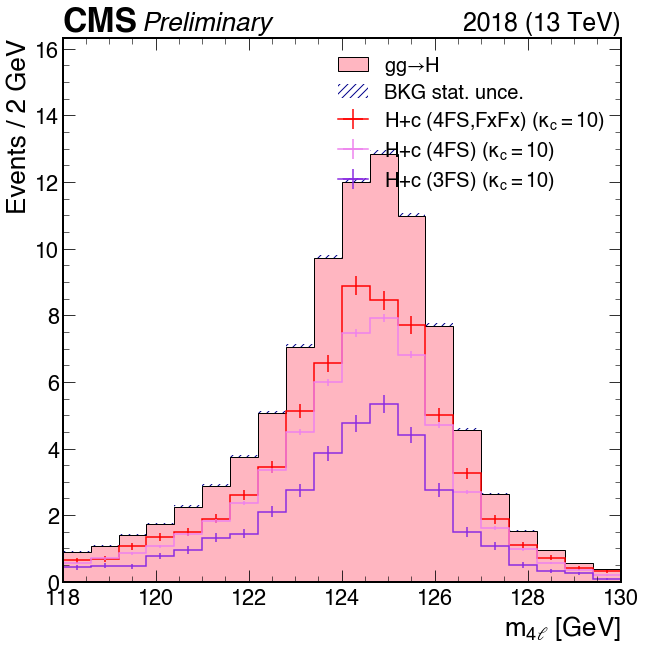

In [87]:
d = {}
for sam in fileset:
    d[sam] = arr[sam][(arr[sam].passedFullSelection)]
    
make_plot(title='mass4l', nbin=20, xmin=118, xmax=130, kc=10, 
    content_arr='d[sam].mass4l',
    weight_arr='d[sam].weight',
    xlabel=r'$m_{4\ell}$ [GeV]', ylabel='Events / 2 GeV', ylog=False, custom_bkg=['ggH125'],
    custom_command="ax.legend(prop={'size': 20}, ncol=1, labelspacing=0.3, borderpad=0.3)",
    store_plot=True
)
# make_plot(title='D_bkg_kin', nbin=20, xmin=0, xmax=1, kc=10, 
#     content_arr='d[sam].D_bkg_kin',
#     weight_arr='d[sam].weight',
#     xlabel=r'$D_{bkg}^{kin}$', ylabel='Events / 0.05', ylog=False, custom_bkg=['ggH125'],
#     custom_command="ax.legend(prop={'size': 20}, ncol=1, labelspacing=0.3, borderpad=0.3)",
#     store_plot=False
# )

## Flavours for ggH

In [99]:
def make_plot_ggh_flv(title, nbin=50, xmin=70, xmax=170, kc=10, content_arr='arr[sam].ZZMass', flv_arr='', weight_arr='arr[sam].weight', xlabel=r'$m_{4\ell}$ [GeV]', ylabel='Events / 2 GeV', 
        ylog=False, custom_command=None, store_plot=False):

    f, ax = plt.subplots(figsize=(10, 10))
    hep.cms.label(data=True, llabel='Preliminary', year=2018, ax=ax, fontname='sans-serif') # llabel='Work in progress'

    plot_bkg_info = {
        'l': ('ggH (flv L)', 'gainsboro'),
        'b': ('ggH (flv B)', 'plum'),
        'c': ('ggH (flv C)', 'cornflowerblue'),
    }
    # get weighted boost histogram
    hist = {}
    flv_map = {'l': 0, 'b': 5, 'c': 4}
    for flv in 'lbc':
        if isinstance(nbin, int):
            axis = bh.axis.Regular(nbin, xmin, xmax)
        else:
            axis = bh.axis.Variable(nbin)
        hist[flv] = bh.Histogram(axis, storage=bh.storage.Weight())
        hist[flv].fill(eval(f'{content_arr}[{flv_arr} == {flv_map[flv]}]'), weight=eval(f'{weight_arr}[{flv_arr} == {flv_map[flv]}]')) # replace None value with 1e20
    hist_add = sum([hist[k] for k in hist])

    # make stacked plot
    hep.histplot(
        [hist[k].view().value for k in hist], 
        bins=hist_add.axes[0].edges,
        yerr=[np.sqrt(hist[k].view().variance) for k in hist],
        label=[plot_bkg_info[k][0] for k in hist], color=[plot_bkg_info[k][1] for k in hist], 
        histtype='fill', edgecolor='k', linewidth=1, stack=True,
    )

    # plot signal stat uncertainties
    bkgtot, bkgtot_err = hist_add.view(flow=False).value, np.sqrt(hist_add.view(flow=False).variance)
    ax.fill_between(hist_add.axes[0].edges, (bkgtot-bkgtot_err).tolist()+[0], (bkgtot+bkgtot_err).tolist()+[0], label='BKG stat. unce.', step='post', hatch='///', edgecolor='darkblue', facecolor='none', linewidth=0) ## draw bkg unce.

    ax.legend(prop={'size': 20}, ncol=2, labelspacing=0.3, borderpad=0.3)
    ax.set_xlabel(xlabel, ha='right', x=1.0); ax.set_ylabel(ylabel, ha='right', y=1.0);
    ax.set_xlim(xmin, xmax); ax.set_ylim(0, ax.get_ylim()[1]*1.2)
    if ylog:
        ax.set_yscale('log')
    if custom_command is not None:
        exec(custom_command)
    
    if store_plot:
        store_dir = '../plots/histo_0906/'
        plt.savefig(store_dir + f'/ggh_{title}.jpg')
        plt.savefig(store_dir + f'/ggh_{title}.pdf')


In [90]:
sam = 'ggH125'
d = arr[sam][(arr[sam].passedFullSelection) & (arr[sam].mass4l>118) & (arr[sam].mass4l<130) & (ak.num(arr[sam].jet_iscleanH4l)>0)]
dic = {}
dic['cleanjet_pt'] = d.jet_pt[d.jet_iscleanH4l]
dic['cleanjet_DeepJet_CvsL'] = d.jet_DeepJet_CvsL[d.jet_iscleanH4l]
dic['cleanjet_DeepJet_CvsB'] = d.jet_DeepJet_CvsB[d.jet_iscleanH4l]
dic['cleanjet_ParticleNet_CvsL'] = d.jet_ParticleNet_CvsL[d.jet_iscleanH4l]
dic['cleanjet_ParticleNet_CvsB'] = d.jet_ParticleNet_CvsB[d.jet_iscleanH4l]
dic['cleanjet_hadronFlavour'] = d.jet_hadronFlavour[d.jet_iscleanH4l]
dic['cleanjet_ParticleNet_CvsL_maxPNet'] = ak.max(dic["cleanjet_ParticleNet_CvsL"], axis=-1)
dic['cleanjet_DeepJet_CvsL_maxDJ'] = ak.max(dic["cleanjet_DeepJet_CvsL"], axis=-1)
dic['cleanjet_hadronFlavour_maxDJ'] = ak.fill_none(dic["cleanjet_hadronFlavour"].mask[ak.num(dic["cleanjet_pt"])>0][ak.singletons(ak.argmax(dic["cleanjet_DeepJet_CvsL"], axis=-1))][:,0], -1)
dic['cleanjet_hadronFlavour_maxPNet'] = ak.fill_none(dic["cleanjet_hadronFlavour"].mask[ak.num(dic["cleanjet_pt"])>0][ak.singletons(ak.argmax(dic["cleanjet_ParticleNet_CvsL"], axis=-1))][:,0], -1)
dic['cleanjet_hadronFlavour_maxPt'] = ak.fill_none(dic["cleanjet_hadronFlavour"].mask[ak.num(dic["cleanjet_pt"])>0][ak.singletons(ak.argmax(dic["cleanjet_pt"], axis=-1))][:,0], -1)

dic['cleanjet_mass_maxDJ'] = ak.fill_none(d.jet_mass[d.jet_iscleanH4l].mask[ak.num(dic["cleanjet_pt"])>0][ak.singletons(ak.argmax(dic["cleanjet_DeepJet_CvsL"], axis=-1))][:,0], -1)

In [91]:
# match target jet to sv
assert all(ak.num(dic["cleanjet_pt"]) > 0)
tar_jet = ak.zip(
    dict(
        pt=d.jet_pt[d.jet_iscleanH4l][ak.singletons(ak.argmax(dic["cleanjet_DeepJet_CvsL"], axis=-1))],
        eta=d.jet_eta[d.jet_iscleanH4l][ak.singletons(ak.argmax(dic["cleanjet_DeepJet_CvsL"], axis=-1))],
        phi=d.jet_phi[d.jet_iscleanH4l][ak.singletons(ak.argmax(dic["cleanjet_DeepJet_CvsL"], axis=-1))],
        mass=d.jet_mass[d.jet_iscleanH4l][ak.singletons(ak.argmax(dic["cleanjet_DeepJet_CvsL"], axis=-1))],
    ),
    behavior=vector.behavior,
    with_name='PtEtaPhiMLorentzVector',
)

svs = ak.zip(
    dict(
        pt=d.sv_pt,
        eta=d.sv_eta,
        phi=d.sv_phi,
        mass=d.sv_mass,
    ),
    behavior=vector.behavior,
    with_name='PtEtaPhiMLorentzVector',
)

# clean sv
from importlib import reload
import utils
utils = reload(utils)
sv_is_cleaned = utils.clean_sv(d)
cleaned_svs = svs[sv_is_cleaned]

# match with jets
comb = ak.cartesian([tar_jet, cleaned_svs], nested=True)
dr = comb['0'].delta_r(comb['1'])

HC_4FSFxFx


ValueError: key "HC_4FSFxFx" does not exist (not in record)

(https://github.com/scikit-hep/awkward-1.0/blob/1.8.0/src/libawkward/util.cpp#L525)

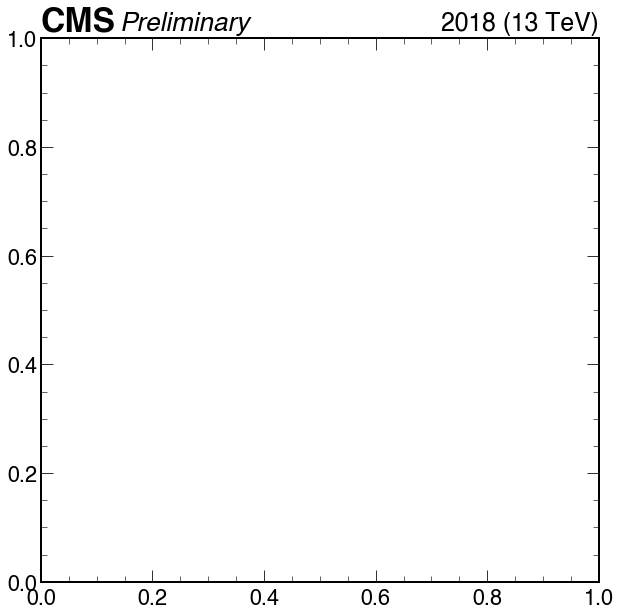

In [102]:
slice_str = "dic['cleanjet_DeepJet_CvsL_maxDJ']>0.3"
make_plot(title='mass4l', nbin=20, xmin=118, xmax=130, kc=10, 
    content_arr='d[sam].mass4l',
    weight_arr='d[sam].weight',
    xlabel=r'$m_{4\ell}$ [GeV]', ylabel='Events / 2 GeV', ylog=False, custom_bkg=['ggH125'],
    custom_command="ax.legend(prop={'size': 20}, ncol=1, labelspacing=0.3, borderpad=0.3)",
    store_plot=False
)

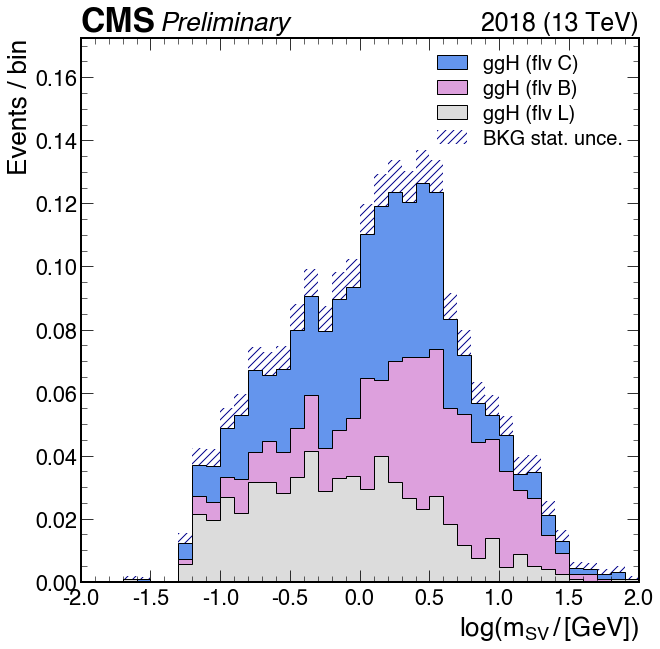

In [100]:
slice_str = "dic['cleanjet_DeepJet_CvsL_maxDJ']>0.3"
make_plot_ggh_flv(title='cleanedsv_mass_mindr_log', nbin=40, xmin=-2, xmax=2, kc=10, 
    content_arr=f"np.log(ak.fill_none(ak.firsts(cleaned_svs.mass[ak.argmin(dr, axis=-1)]), 0) + 1e-20)[{slice_str}]",
    flv_arr=f"dic['cleanjet_hadronFlavour_maxDJ'][{slice_str}]",
    weight_arr=f"d.weight[{slice_str}]",
    xlabel=r'$log(m_{SV} \,/\, [GeV])$', ylabel='Events / bin', ylog=False,
    custom_command="ax.legend(prop={'size': 20}, ncol=1, labelspacing=0.3, borderpad=0.3)",
    store_plot=True
)

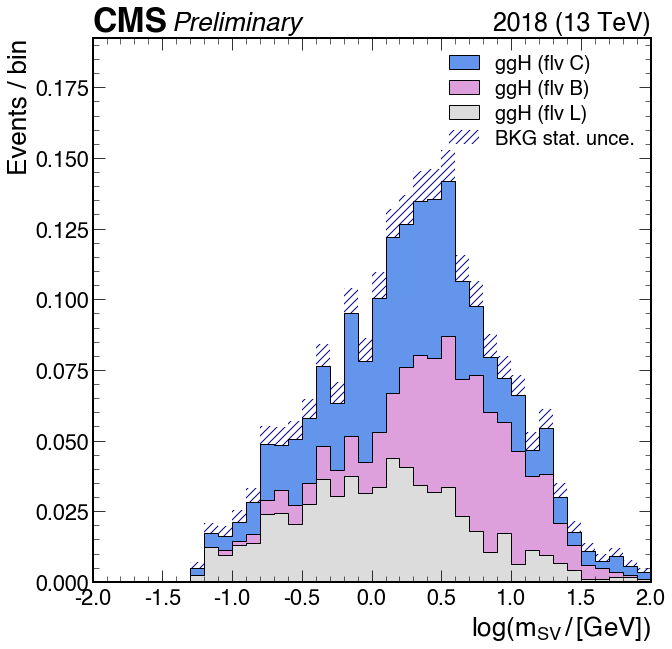

In [101]:
# slice_str = "dic['cleanjet_DeepJet_CvsL_maxDJ']>0.3"
# make_plot_ggh_flv(title='cleanjet_mass_maxDJ', nbin=40, xmin=1, xmax=4, kc=10, 
#     content_arr=f"np.log(dic['cleanjet_mass_maxDJ'] + 1e-20)[{slice_str}]",
#     flv_arr=f"dic['cleanjet_hadronFlavour_maxDJ'][{slice_str}]",
#     weight_arr=f"d.weight[{slice_str}]",
#     xlabel=r'$D_{bkg}^{kin}$', ylabel='Events / 5 GeV', ylog=False,
#     custom_command="ax.legend(prop={'size': 20}, ncol=1, labelspacing=0.3, borderpad=0.3)",
#     store_plot=False
# )
slice_str = "dic['cleanjet_DeepJet_CvsL_maxDJ']>0.3"
make_plot_ggh_flv(title='cleanedsv_mass_max_log', nbin=40, xmin=-2, xmax=2, kc=10, 
    content_arr=f"np.log(ak.fill_none(ak.max(cleaned_svs.mass, axis=-1), 0) + 1e-20)[{slice_str}]",
    flv_arr=f"dic['cleanjet_hadronFlavour_maxDJ'][{slice_str}]",
    weight_arr=f"d.weight[{slice_str}]",
    xlabel=r'$log(m_{SV} \,/\, [GeV])$', ylabel='Events / bin', ylog=False,
    custom_command="ax.legend(prop={'size': 20}, ncol=1, labelspacing=0.3, borderpad=0.3)",
    store_plot=True
)

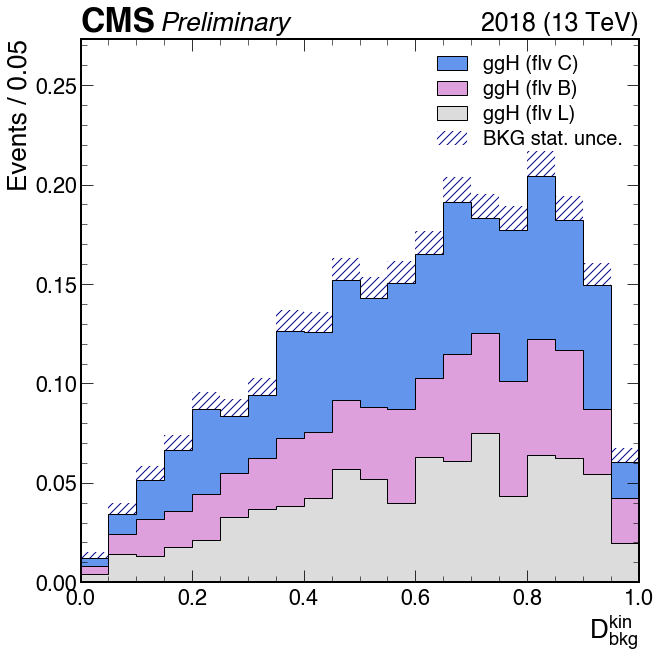

In [42]:
# make_plot_ggh_flv(title='D_bkg_kin', nbin=20, xmin=0, xmax=1, kc=10, 
#     content_arr='d.D_bkg_kin',
#     flv_arr="dic['cleanjet_hadronFlavour_maxPNet']",
#     weight_arr='d.weight',
#     xlabel=r'$D_{bkg}^{kin}$', ylabel='Events / 0.05', ylog=False,
#     custom_command="ax.legend(prop={'size': 20}, ncol=1, labelspacing=0.3, borderpad=0.3)",
#     store_plot=False
# )
# slice_str = "dic['cleanjet_ParticleNet_CvsL_maxPNet']>0.3"
# make_plot_ggh_flv(title='D_bkg_kin', nbin=20, xmin=0, xmax=1, kc=10, 
#     content_arr=f"d.D_bkg_kin[{slice_str}]",
#     flv_arr=f"dic['cleanjet_hadronFlavour_maxPNet'][{slice_str}]",
#     weight_arr=f"d.weight[{slice_str}]",
#     xlabel=r'$D_{bkg}^{kin}$', ylabel='Events / 0.05', ylog=False,
#     custom_command="ax.legend(prop={'size': 20}, ncol=1, labelspacing=0.3, borderpad=0.3)",
#     store_plot=False
# )

## Flavours for ggH+cH

In [32]:
d, dic = {}, {}
for sam in ['ggH125', 'HC_4FSFxFx']:
    d[sam] = arr[sam][(arr[sam].passedFullSelection) & (arr[sam].mass4l>118) & (arr[sam].mass4l<130) & (ak.num(arr[sam].jet_iscleanH4l)>0)]
    dic[sam] = {}
    dic[sam]['cleanjet_pt'] = d[sam].jet_pt[d[sam].jet_iscleanH4l]
    dic[sam]['cleanjet_DeepJet_CvsL'] = d[sam].jet_DeepJet_CvsL[d[sam].jet_iscleanH4l]
    dic[sam]['cleanjet_DeepJet_CvsB'] = d[sam].jet_DeepJet_CvsB[d[sam].jet_iscleanH4l]
    dic[sam]['cleanjet_ParticleNet_CvsL'] = d[sam].jet_ParticleNet_CvsL[d[sam].jet_iscleanH4l]
    dic[sam]['cleanjet_ParticleNet_CvsB'] = d[sam].jet_ParticleNet_CvsB[d[sam].jet_iscleanH4l]
    dic[sam]['cleanjet_hadronFlavour'] = d[sam].jet_hadronFlavour[d[sam].jet_iscleanH4l]
    dic[sam]['cleanjet_ParticleNet_CvsL_maxPNet'] = ak.max(dic[sam]["cleanjet_ParticleNet_CvsL"], axis=-1)
    dic[sam]['cleanjet_DeepJet_CvsL_maxDJ'] = ak.max(dic[sam]["cleanjet_DeepJet_CvsL"], axis=-1)
    dic[sam]['cleanjet_DeepJet_CvsL_maxpt'] = dic[sam]["cleanjet_DeepJet_CvsL"][:, 0]
    dic[sam]['cleanjet_ParticleNet_CvsL_maxpt'] = dic[sam]["cleanjet_ParticleNet_CvsL"][:, 0]
    dic[sam]['cleanjet_hadronFlavour_maxDJ'] = ak.fill_none(dic[sam]["cleanjet_hadronFlavour"].mask[ak.num(dic[sam]["cleanjet_pt"])>0][ak.singletons(ak.argmax(dic[sam]["cleanjet_DeepJet_CvsL"], axis=-1))][:,0], -1)
    dic[sam]['cleanjet_hadronFlavour_maxPNet'] = ak.fill_none(dic[sam]["cleanjet_hadronFlavour"].mask[ak.num(dic[sam]["cleanjet_pt"])>0][ak.singletons(ak.argmax(dic[sam]["cleanjet_ParticleNet_CvsL"], axis=-1))][:,0], -1)
    dic[sam]['cleanjet_hadronFlavour_maxPt'] = ak.fill_none(dic[sam]["cleanjet_hadronFlavour"].mask[ak.num(dic[sam]["cleanjet_pt"])>0][ak.singletons(ak.argmax(dic[sam]["cleanjet_pt"], axis=-1))][:,0], -1)

    dic[sam]['cleanjet_mass_maxDJ'] = ak.fill_none(d[sam].jet_mass[d[sam].jet_iscleanH4l].mask[ak.num(dic[sam]["cleanjet_pt"])>0][ak.singletons(ak.argmax(dic[sam]["cleanjet_DeepJet_CvsL"], axis=-1))][:,0], -1)

In [33]:
for sam in ['ggH125', 'HC_4FSFxFx']:
    # match target jet to sv
    assert all(ak.num(dic[sam]["cleanjet_pt"]) > 0)
    tar_jet = ak.zip(
        dict(
            pt=d[sam].jet_pt[d[sam].jet_iscleanH4l][ak.singletons(ak.argmax(dic[sam]["cleanjet_DeepJet_CvsL"], axis=-1))],
            eta=d[sam].jet_eta[d[sam].jet_iscleanH4l][ak.singletons(ak.argmax(dic[sam]["cleanjet_DeepJet_CvsL"], axis=-1))],
            phi=d[sam].jet_phi[d[sam].jet_iscleanH4l][ak.singletons(ak.argmax(dic[sam]["cleanjet_DeepJet_CvsL"], axis=-1))],
            mass=d[sam].jet_mass[d[sam].jet_iscleanH4l][ak.singletons(ak.argmax(dic[sam]["cleanjet_DeepJet_CvsL"], axis=-1))],
        ),
        behavior=vector.behavior,
        with_name='PtEtaPhiMLorentzVector',
    )

    svs = ak.zip(
        dict(
            pt=d[sam].sv_pt,
            eta=d[sam].sv_eta,
            phi=d[sam].sv_phi,
            mass=d[sam].sv_mass,
        ),
        behavior=vector.behavior,
        with_name='PtEtaPhiMLorentzVector',
    )

    # clean sv
    from importlib import reload
    import utils
    utils = reload(utils)
    sv_is_cleaned = utils.clean_sv(d[sam])
    dic[sam]['cleaned_svs_lo'] = svs[sv_is_cleaned]

    # # match with jets
    # comb = ak.cartesian([tar_jet, cleaned_svs], nested=True)
    # dr = comb['0'].delta_r(comb['1'])

    dic[sam]['cleaned_svs_mass_max'] = ak.fill_none(ak.max(dic[sam]['cleaned_svs_lo'].mass, axis=-1), -1)

In [47]:
def make_plot_flv(title, nbin=50, xmin=70, xmax=170, kc=10, content_arr='arr[sam].ZZMass', flv_arr='', weight_arr='arr[sam].weight', xlabel=r'$m_{4\ell}$ [GeV]', ylabel='Events / 2 GeV', 
        ylog=False, custom_command=None, store_plot=False):

    f, ax = plt.subplots(figsize=(10, 10))
    hep.cms.label(data=True, llabel='Preliminary', year=2018, ax=ax, fontname='sans-serif') # llabel='Work in progress'

    plot_bkg_info = {
        'ggH125l': ('ggH (flv L)', 'lightgrey'),
        'ggH125b': ('ggH (flv B)', 'violet'),
        'ggH125c': ('ggH (flv C)', 'royalblue'),
        'HC_4FSFxFxl': ('H+c $(\kappa_c=10)$ (flv L)', 'gainsboro'),
        'HC_4FSFxFxb': ('H+c $(\kappa_c=10)$ (flv B)', 'plum'),
        'HC_4FSFxFxc': ('H+c $(\kappa_c=10)$ (flv C)', 'cornflowerblue'),
    }
    histkey = plot_bkg_info.keys()
    # get weighted boost histogram
    hist = {}
    flv_map = {'l': 0, 'b': 5, 'c': 4}
    for sam in ['ggH125', 'HC_4FSFxFx']:
        for flv in 'lbc':
            if isinstance(nbin, int):
                axis = bh.axis.Regular(nbin, xmin, xmax)
            else:
                axis = bh.axis.Variable(nbin)
            hist[sam+flv] = bh.Histogram(axis, storage=bh.storage.Weight())
            hist[sam+flv].fill(eval(f'{content_arr}[{flv_arr} == {flv_map[flv]}]'), weight=eval(f'{weight_arr}[{flv_arr} == {flv_map[flv]}]')) # replace None value with 1e20
            if sam == 'HC_4FSFxFx':
                hist[sam+flv].view().value = hist[sam+flv].view().value * 100
                hist[sam+flv].view().variance = hist[sam+flv].view().variance * 100**2

    hist_add = sum([hist[k] for k in hist])
    print(hist['ggH125c'].view().value / hist['ggH125l'].view().value, hist['ggH125b'].view().value / hist['ggH125l'].view().value)

    # make stacked plot
    hep.histplot(
        [hist[k].view().value for k in histkey], 
        bins=hist_add.axes[0].edges,
        yerr=[np.sqrt(hist[k].view().variance) for k in histkey],
        label=[plot_bkg_info[k][0] for k in histkey], color=[plot_bkg_info[k][1] for k in histkey], 
        histtype='fill', edgecolor='k', linewidth=1, stack=True,
    )

    # plot signal stat uncertainties
    bkgtot, bkgtot_err = hist_add.view(flow=False).value, np.sqrt(hist_add.view(flow=False).variance)
    ax.fill_between(hist_add.axes[0].edges, (bkgtot-bkgtot_err).tolist()+[0], (bkgtot+bkgtot_err).tolist()+[0], label='BKG stat. unce.', step='post', hatch='///', edgecolor='darkblue', facecolor='none', linewidth=0) ## draw bkg unce.

    ax.legend(prop={'size': 20}, ncol=2, labelspacing=0.3, borderpad=0.3)
    ax.set_xlabel(xlabel, ha='right', x=1.0); ax.set_ylabel(ylabel, ha='right', y=1.0);
    ax.set_xlim(xmin, xmax); ax.set_ylim(0, ax.get_ylim()[1]*1.2)
    if ylog:
        ax.set_yscale('log')
    if custom_command is not None:
        exec(custom_command)
    
    if store_plot:
        store_dir = '../plots/histo_0912/'
        plt.savefig(store_dir + f'/ggh_{title}.jpg')
        plt.savefig(store_dir + f'/ggh_{title}.pdf')


In [36]:
dic[sam]['cleanjet_DeepJet_CvsL_maxpt']

<Array [0.717, 0.0845] type='2 * float32'>

[0.35520791] [0.46667667]


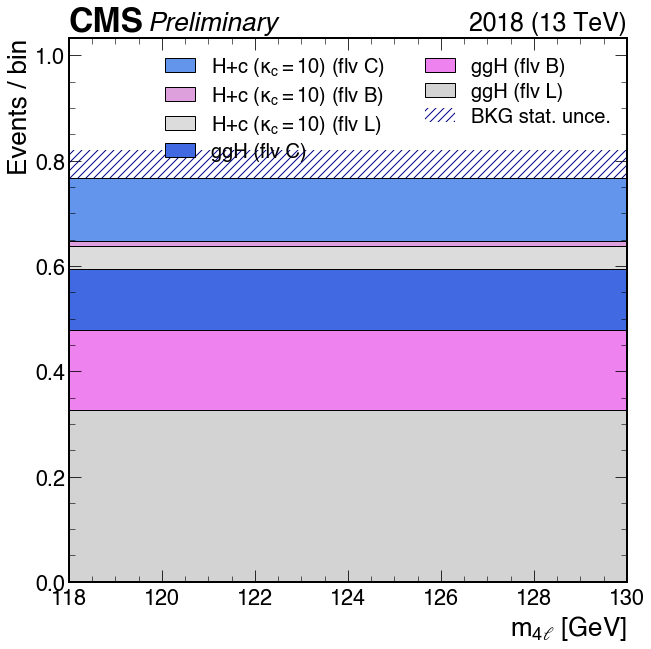

In [62]:
# # inclusive plots
# slice_str = "dic[sam]['cleanjet_DeepJet_CvsL_maxpt']>0.0"
# make_plot_flv(title='incl', nbin=1, xmin=118, xmax=130, kc=10, 
# # make_plot_flv(title='incl_dj0p1', nbin=1, xmin=118, xmax=130, kc=10, 
#     content_arr=f'd[sam].mass4l[{slice_str}]',
#     flv_arr=f"dic[sam]['cleanjet_hadronFlavour_maxDJ'][{slice_str}]",
#     weight_arr=f'd[sam].weight[{slice_str}]',
#     xlabel=r'$m_{4\ell}$ [GeV]', ylabel='Events / bin', ylog=False,
#     custom_command="ax.legend(prop={'size': 20}, ncol=2, labelspacing=0.3, borderpad=0.3); ax.set_ylim(0, 50)",
#     store_plot=True
# )

# slice_str = "(dic[sam]['cleanjet_DeepJet_CvsL_maxpt']>0.1) & (dic[sam]['cleanjet_pt'][:,0]<=100)"
# make_plot_flv(title='incl_dj0p1_ptSR', nbin=1, xmin=118, xmax=130, kc=10, 
#     content_arr=f'd[sam].mass4l[{slice_str}]',
#     flv_arr=f"dic[sam]['cleanjet_hadronFlavour_maxDJ'][{slice_str}]",
#     weight_arr=f'd[sam].weight[{slice_str}]',
#     xlabel=r'$m_{4\ell}$ [GeV]', ylabel='Events / bin', ylog=False,
#     custom_command="ax.legend(prop={'size': 20}, ncol=2, labelspacing=0.3, borderpad=0.3)",
#     store_plot=True
# )

# slice_str = "(dic[sam]['cleanjet_DeepJet_CvsL_maxpt']>0.1) & (dic[sam]['cleanjet_pt'][:,0]<=100)"
# make_plot_flv(title='incl_dj0p1_ptSR', nbin=1, xmin=118, xmax=130, kc=10, 
#     content_arr=f'd[sam].mass4l[{slice_str}]',
#     flv_arr=f"dic[sam]['cleanjet_hadronFlavour_maxDJ'][{slice_str}]",
#     weight_arr=f'd[sam].weight[{slice_str}]',
#     xlabel=r'$m_{4\ell}$ [GeV]', ylabel='Events / bin', ylog=False,
#     custom_command="ax.legend(prop={'size': 20}, ncol=2, labelspacing=0.3, borderpad=0.3)",
#     store_plot=True
# )

# slice_str = "(dic[sam]['cleanjet_DeepJet_CvsL_maxpt']>0.1) & (dic[sam]['cleaned_svs_mass_max']>0) & (dic[sam]['cleaned_svs_mass_max']<0.6)"; make_plot_flv(title='incl_dj0p1_lowSvMass', 
# slice_str = "(dic[sam]['cleanjet_DeepJet_CvsL_maxpt']>0.1) & (dic[sam]['cleaned_svs_mass_max']>=0.6) & (dic[sam]['cleaned_svs_mass_max']<2.5)"; make_plot_flv(title='incl_dj0p1_midSvMass', 
slice_str = "(dic[sam]['cleanjet_DeepJet_CvsL_maxpt']>0.1) & (dic[sam]['cleaned_svs_mass_max']>=2.5)"; make_plot_flv(title='incl_dj0p1_highSvMass', 
    nbin=1, xmin=118, xmax=130, kc=10, 
    content_arr=f'd[sam].mass4l[{slice_str}]',
    flv_arr=f"dic[sam]['cleanjet_hadronFlavour_maxDJ'][{slice_str}]",
    weight_arr=f'd[sam].weight[{slice_str}]',
    xlabel=r'$m_{4\ell}$ [GeV]', ylabel='Events / bin', ylog=False,
    custom_command="ax.legend(prop={'size': 20}, ncol=2, labelspacing=0.3, borderpad=0.3)",
    store_plot=True
)

/tmp/ipykernel_2989825/2864280551.py:32: RuntimeWarning: invalid value encountered in true_divide
  print(hist['ggH125c'].view().value / hist['ggH125l'].view().value, hist['ggH125b'].view().value / hist['ggH125l'].view().value)


[       nan        nan        nan 0.                nan 0.04329873
 0.09254806 0.16457297 0.22388738 0.22852564 0.19626533 0.25437596
 0.22282438 0.26451853 0.27651687 0.30970498 0.36767565 0.39292372
 0.39056776 0.43476932 0.33638324 0.32972746 0.30190241 0.34413511
 0.39689047 0.18053765 0.32701689 0.7124487  0.47746076 0.66903923] [       nan        nan        nan 0.                nan 0.
 0.00887487 0.02452494 0.05290651 0.0443892  0.07248863 0.06353887
 0.07215108 0.07839907 0.07036633 0.12020397 0.20247296 0.2527357
 0.29550948 0.3774752  0.48523376 0.53103554 0.54854696 0.45173877
 0.59457827 0.56096865 0.19805275 0.38216183 0.10766823 0.        ]


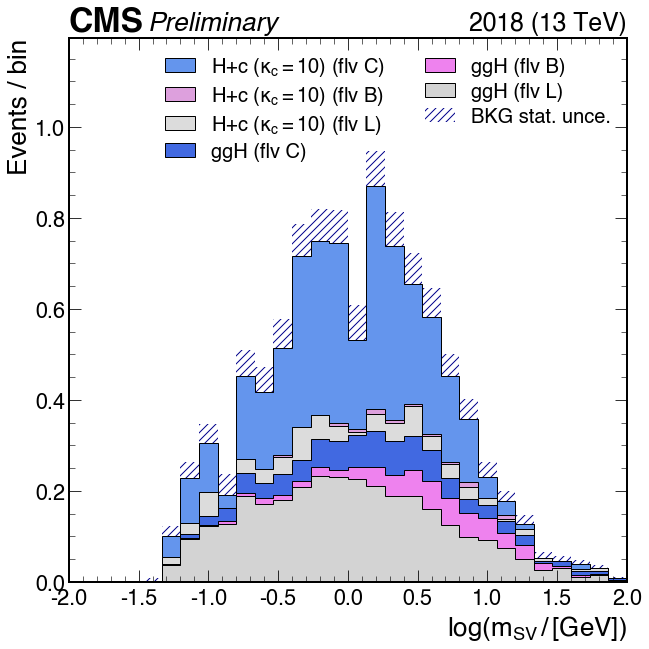

In [56]:
slice_str = "dic[sam]['cleanjet_DeepJet_CvsL_maxpt']>0.1"
make_plot_flv(title='cleanedsv_mass_max_log', nbin=30, xmin=-2, xmax=2, kc=10, 
    content_arr=f"np.log(ak.fill_none(ak.max(dic[sam]['cleaned_svs_lo'].mass, axis=-1), 0) + 1e-20)[{slice_str}]",
    flv_arr=f"dic[sam]['cleanjet_hadronFlavour_maxDJ'][{slice_str}]",
    weight_arr=f"d[sam].weight[{slice_str}]",
    xlabel=r'$log(m_{SV} \,/\, [GeV])$', ylabel='Events / bin', ylog=False,
    custom_command="ax.legend(prop={'size': 20}, ncol=2, labelspacing=0.3, borderpad=0.3)",
    store_plot=False
)
# slice_str = "dic[sam]['cleanjet_DeepJet_CvsL_maxpt']>0.1"
# make_plot_flv(title='ptj', nbin=30, xmin=0, xmax=200, kc=10, 
#     content_arr=f"dic[sam]['cleanjet_pt'][:, 0][{slice_str}]",
#     flv_arr=f"dic[sam]['cleanjet_hadronFlavour_maxDJ'][{slice_str}]",
#     weight_arr=f"d[sam].weight[{slice_str}]",
#     xlabel=r'$p_{T,j}$ [GeV]', ylabel='Events / bin', ylog=False,
#     custom_command="ax.legend(prop={'size': 20}, ncol=2, labelspacing=0.3, borderpad=0.3)",
#     store_plot=True
# )